In [114]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


In [47]:
#df = pd.read_csv('yahoo_stock.csv', parse_dates = ['Date'], index_col = 'Date')
df = get_data("^GSPC")
df = df.drop('ticker', axis=1)
df.head()

,open,high,low,close,adjclose,volume
1970-03-25,0.0,91.070000,88.110001,89.769997,89.769997,17500000
1970-03-26,0.0,90.650002,89.180000,89.919998,89.919998,11350000
1970-03-30,0.0,90.410004,88.910004,89.629997,89.629997,9600000
1970-03-31,0.0,90.169998,88.849998,89.629997,89.629997,8370000
1970-04-01,0.0,90.620003,89.300003,90.070000,90.070000,9810000


In [48]:
df.describe()


,open,high,low,close,adjclose,volume
count,13519.000000,13519.000000,13519.000000,13519.000000,13519.000000,1.351900e+04
mean,1020.715413,1049.895636,1036.941694,1043.823042,1043.823042,1.569188e+09
std,1113.876183,1099.614485,1086.928977,1093.619758,1093.619758,1.866649e+09
min,0.000000,63.230000,60.959999,62.279999,62.279999,0.000000e+00
25%,156.840004,158.050003,156.375000,156.959999,156.959999,8.010000e+07
50%,742.159973,747.539978,736.869995,742.750000,742.750000,4.632300e+08
75%,1389.605042,1399.145020,1378.200012,1390.064941,1390.064941,3.259820e+09
max,4804.509766,4818.620117,4780.040039,4796.560059,4796.560059,1.145623e+10


Ploting the time series

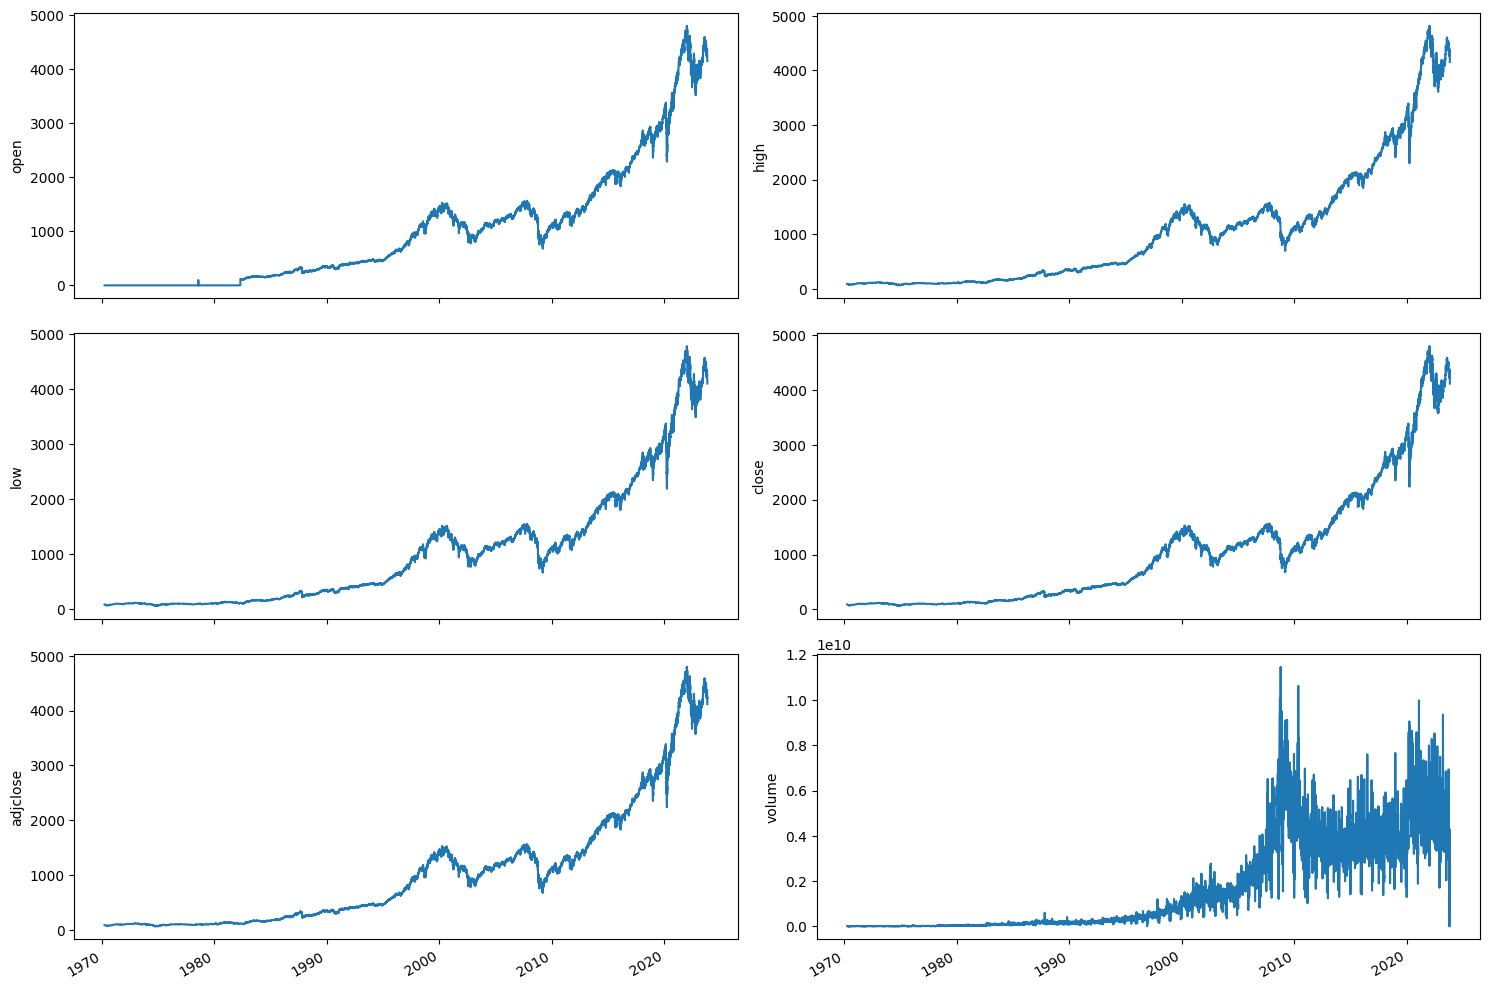

In [49]:
#df.plot(x='Date',y=var)

labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    #plt.scatter(df['Date'],df[label])
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

Removing weekends

In [50]:
#df = df[df.index.weekday < 5]

Chossing variable to study

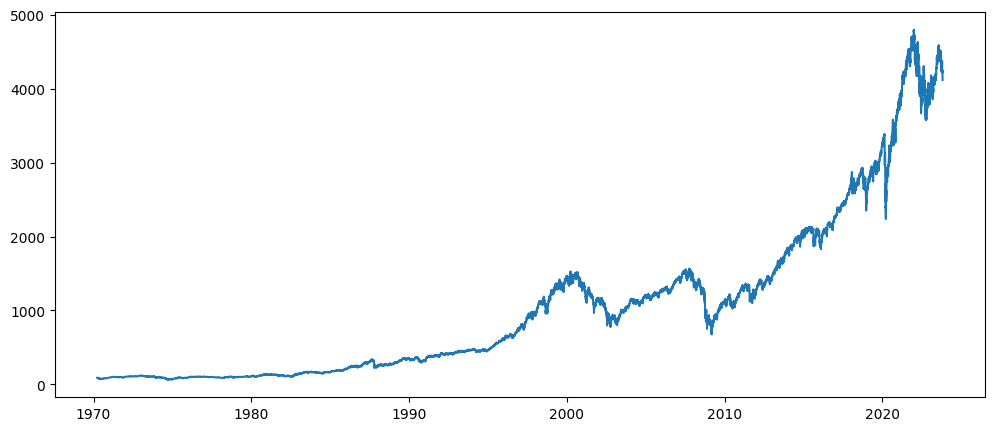

In [51]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

Decomposing the time series

In [73]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

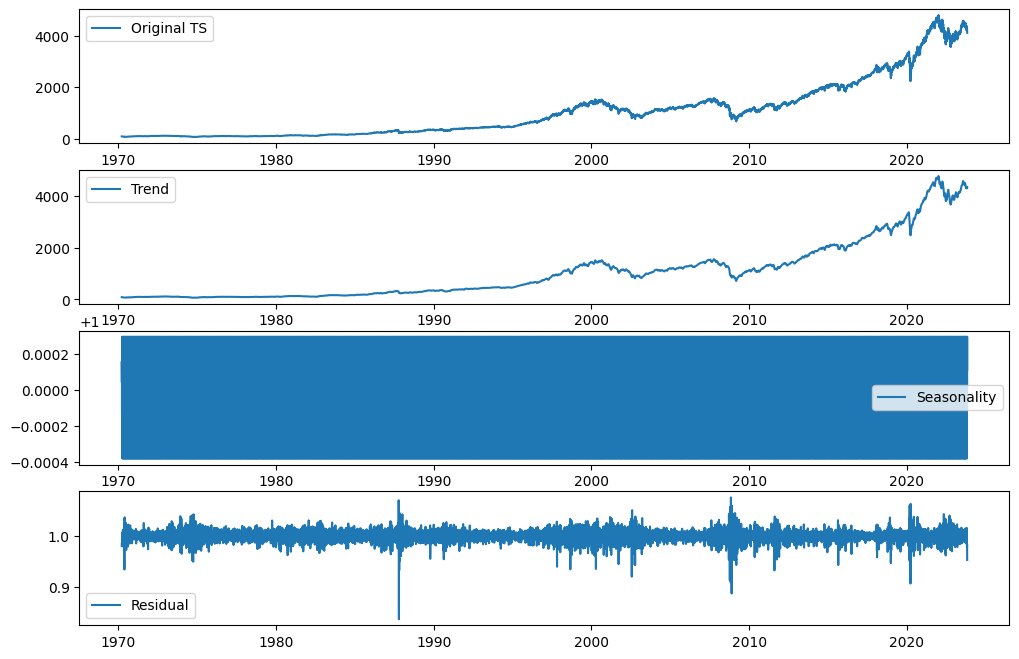

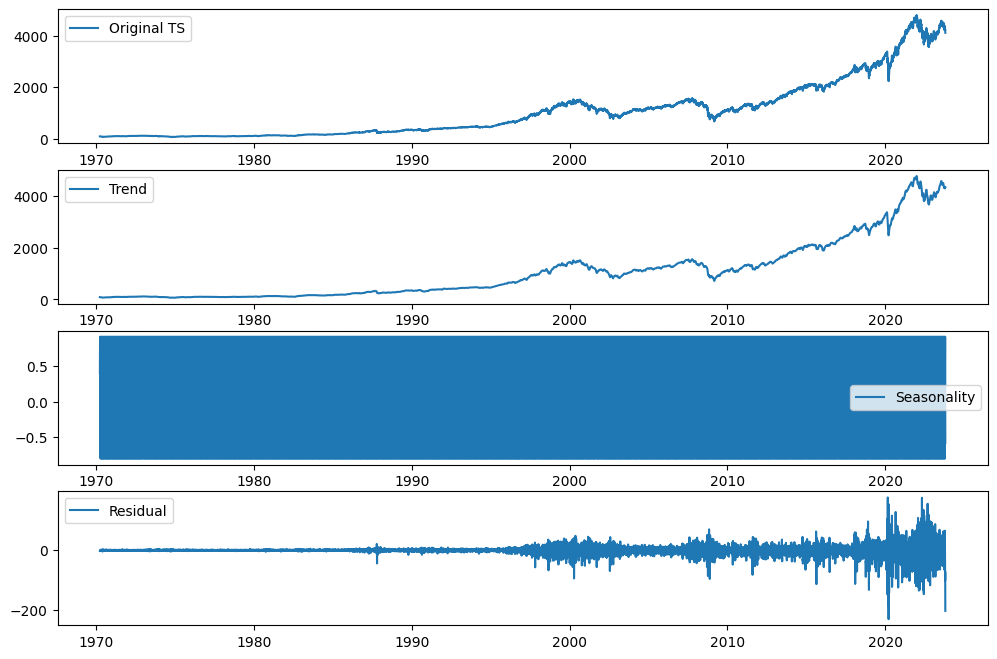

In [74]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


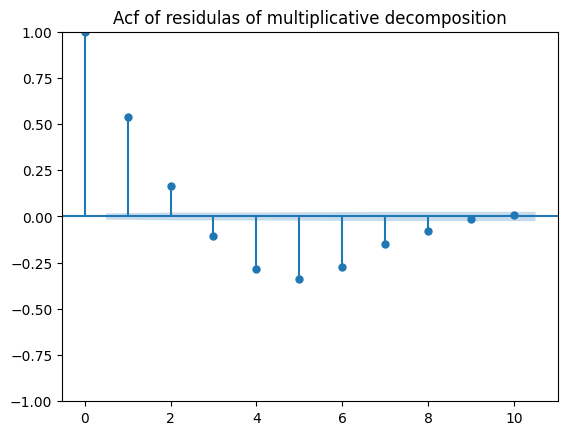

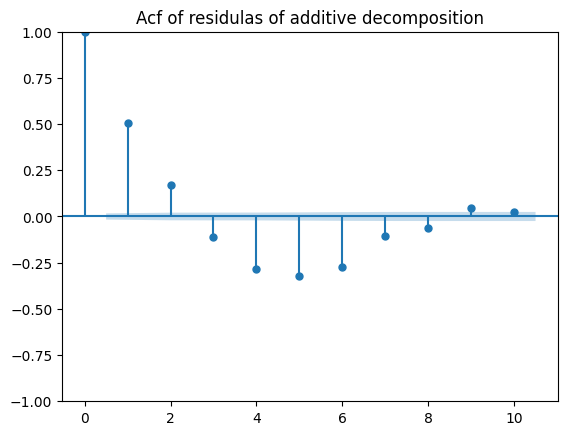

In [83]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

Lag plots

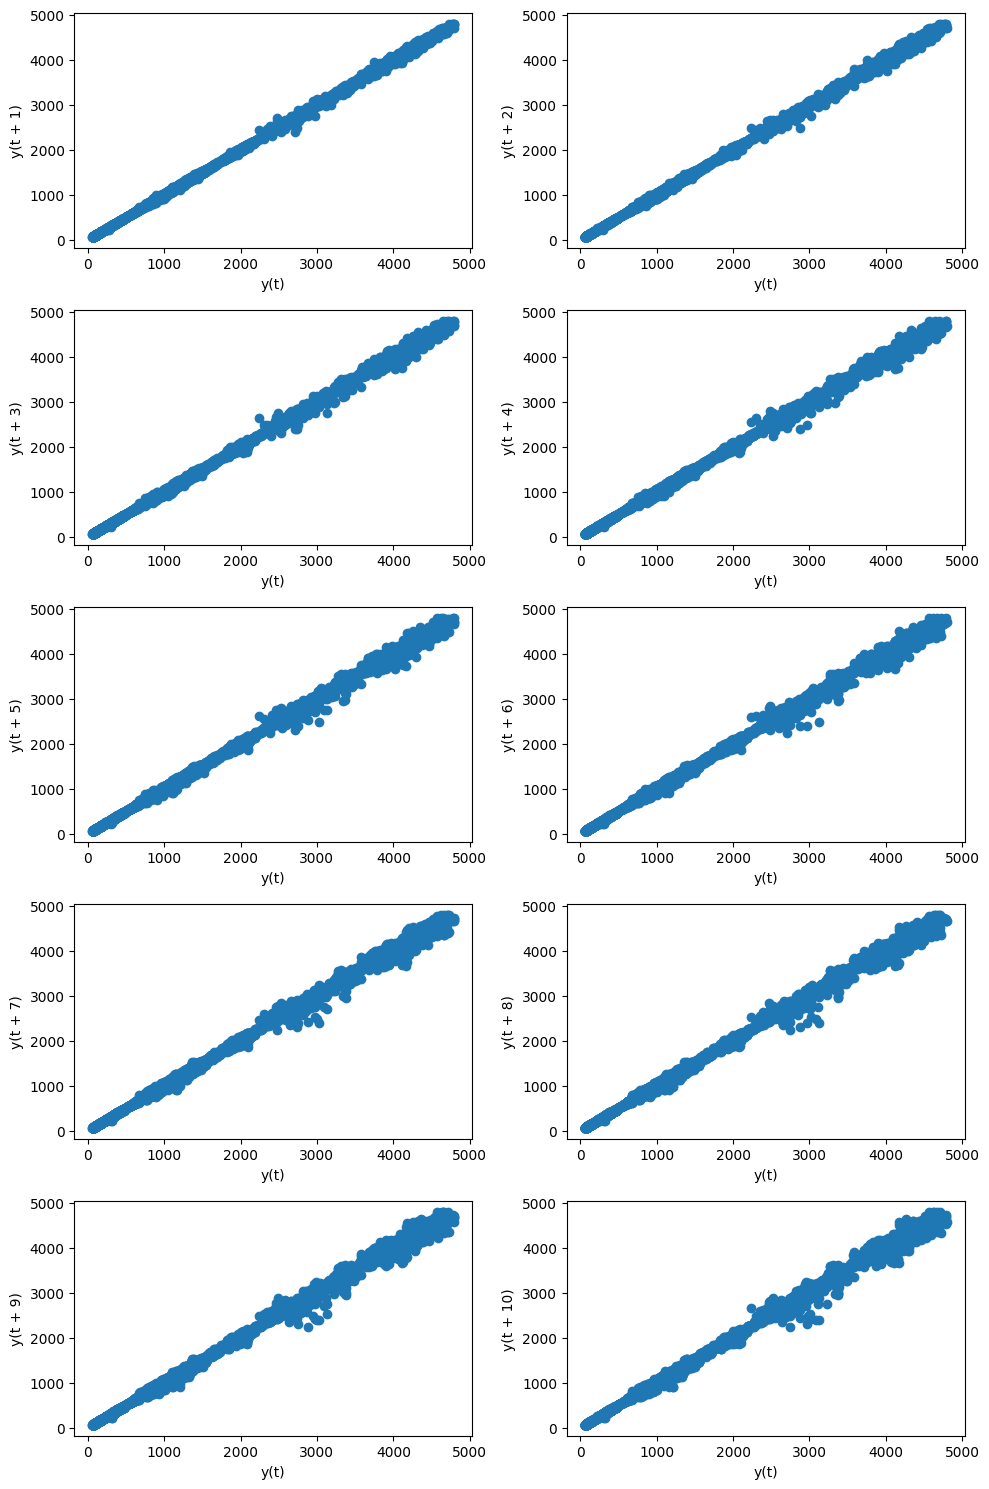

In [55]:
plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


ACF Plot

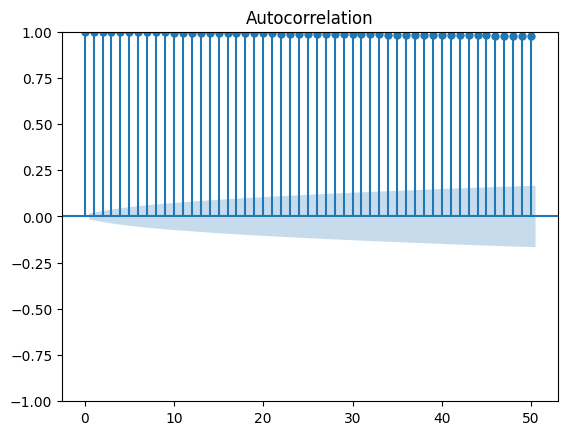

[1.         0.99955689 0.99913188 0.99868985 0.99823981 0.99780383
 0.99736172 0.99692608 0.99646338 0.99600889 0.9955303 ]


In [56]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

Analysing the daily difference

In [110]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


,open,high,low,close,adjclose,volume
count,13518.000000,13518.000000,13518.000000,13518.000000,13518.000000,1.351800e+04
mean,0.307215,0.300757,0.297061,0.297943,0.297943,2.960497e+05
std,15.616079,13.509280,15.291826,17.137523,17.137523,4.457597e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.697502,-1.539978,-1.680000,-1.860001,-1.860001,-3.889750e+07
50%,0.000000,0.109993,0.189999,0.139992,0.139992,1.000000e+04
75%,2.930145,2.459997,2.819969,2.910004,2.910004,3.769000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


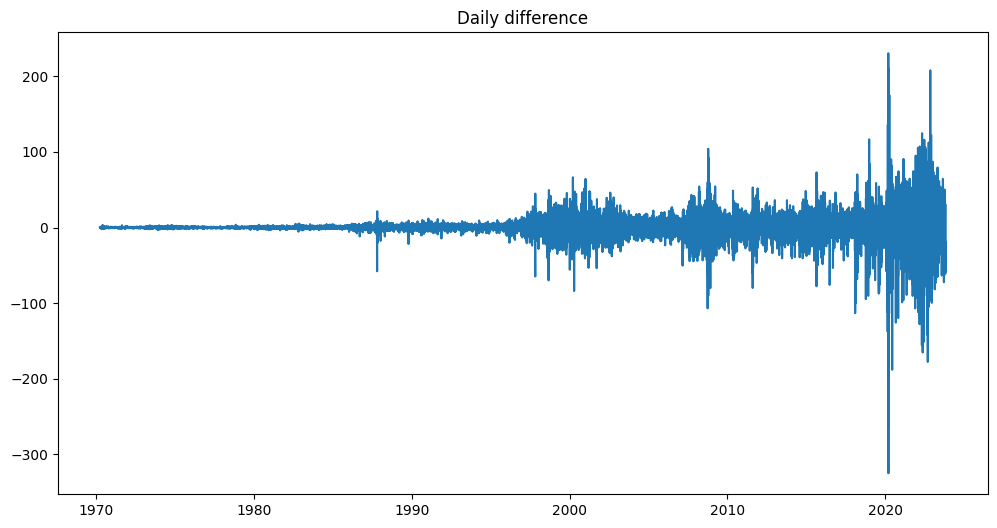

In [111]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

Check for stationary

In [119]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -19.501017397720986
p-value: 0.0
Critical Values: {'1%': -3.4308353477336926, '5%': -2.8617545009207976, '10%': -2.5668841739718493}
The time series is stationary.


KPSS Statistic: 0.4915288054121969
p-value: 0.04357459337563133
The time series is non-stationary.


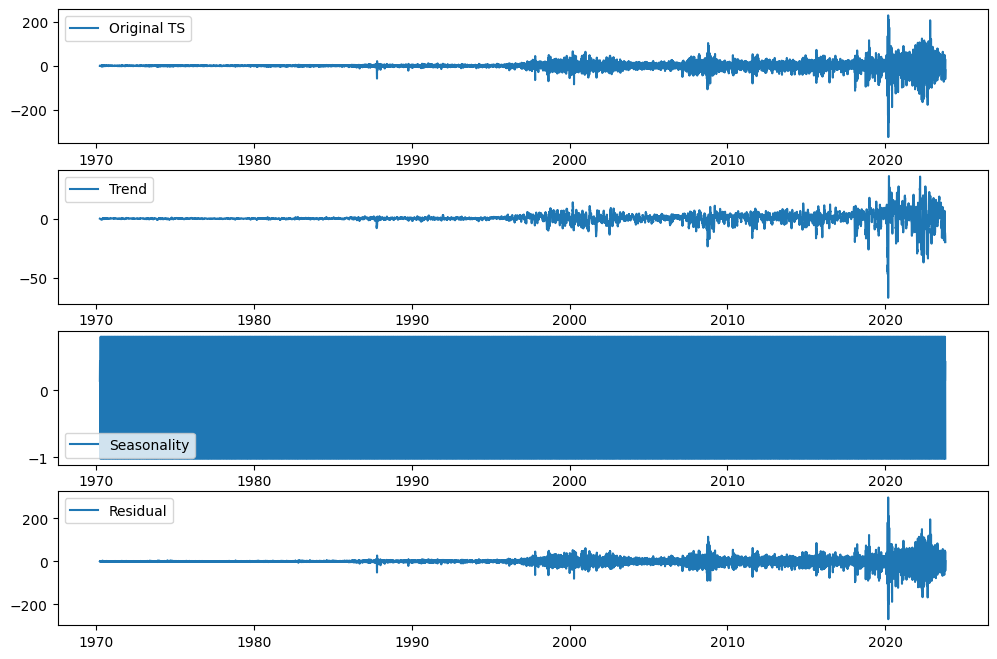

In [103]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=12, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

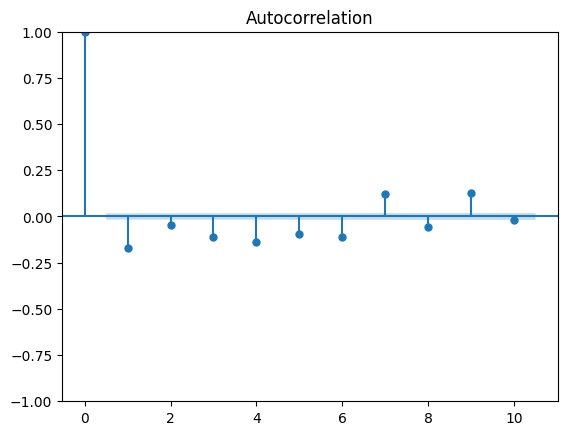

In [104]:
fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.show()

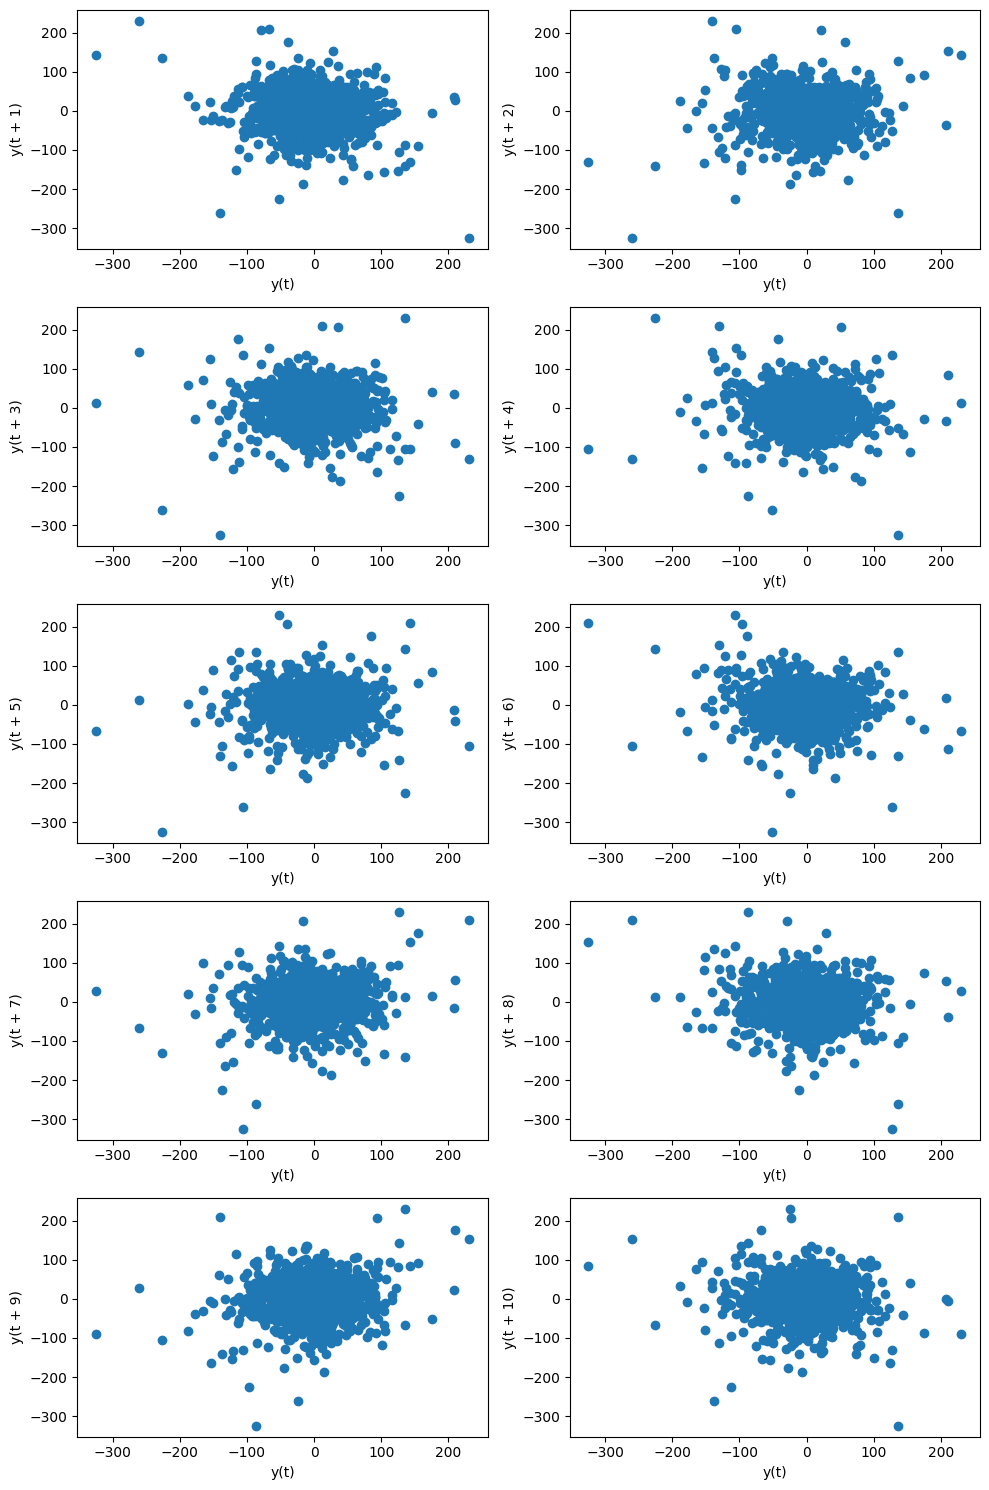

In [60]:
plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

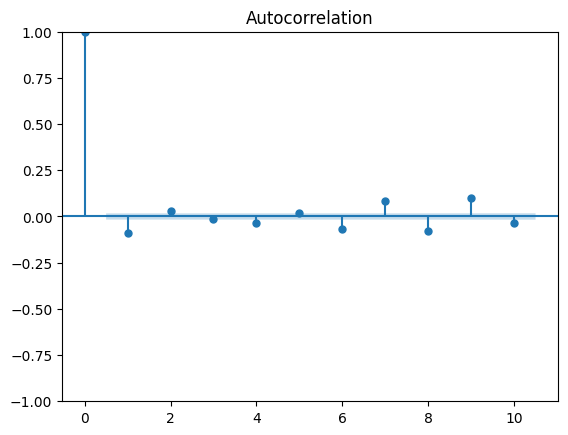

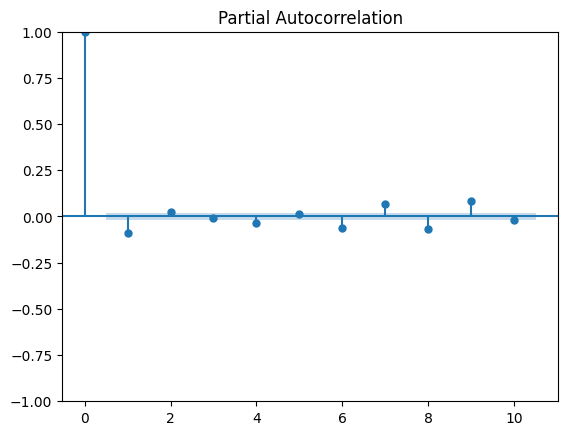

In [120]:
acf= sm.tsa.acf(daily_diff[var])
fig = tsaplots.plot_acf(daily_diff[var], lags=10)
plt.show()

tsaplots.plot_pacf(daily_diff[var],lags=10)
plt.show()

Analysing the data monthly

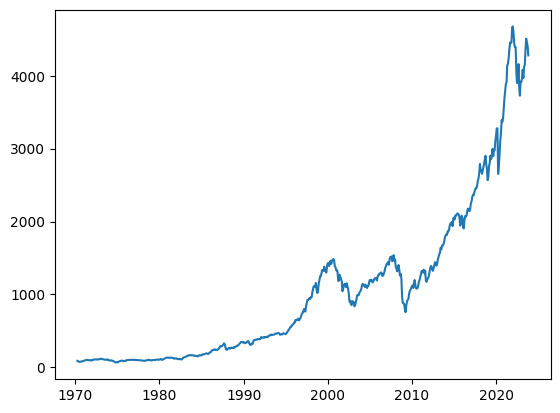

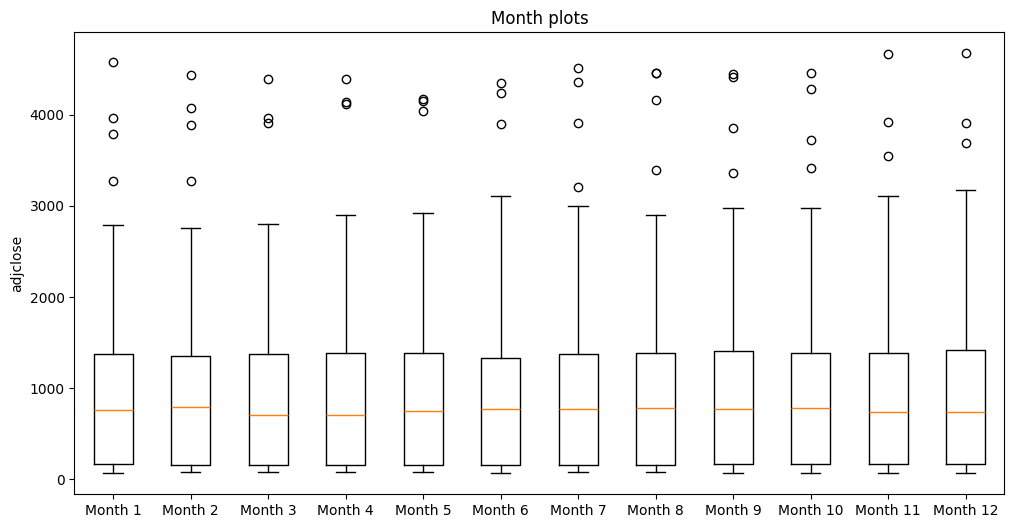

In [62]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()


The evolution of the monthly difference

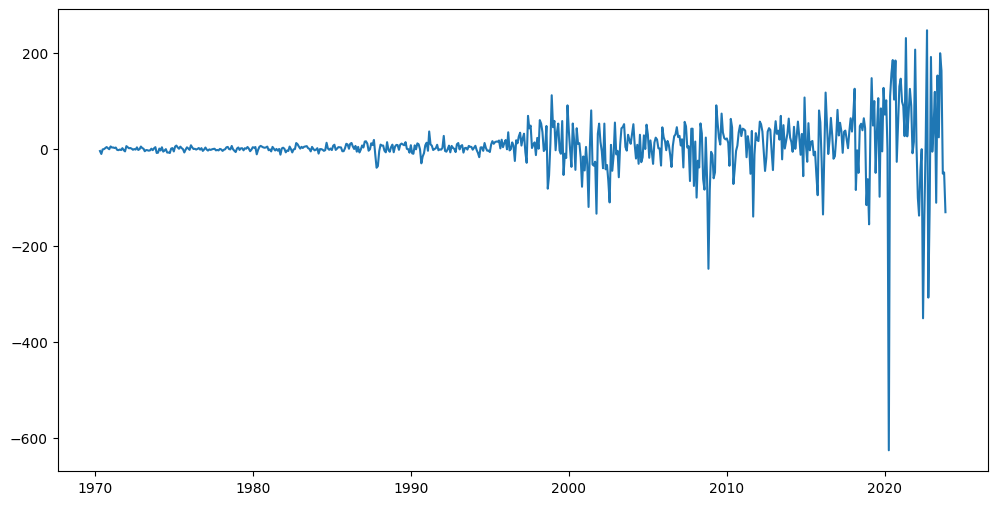

In [63]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

Analysing the box-cox trangormation

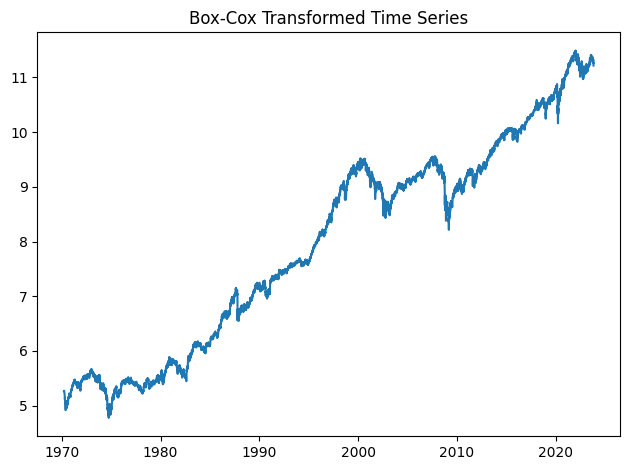

Optimal lambda value: 0.06845813790305294


In [64]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

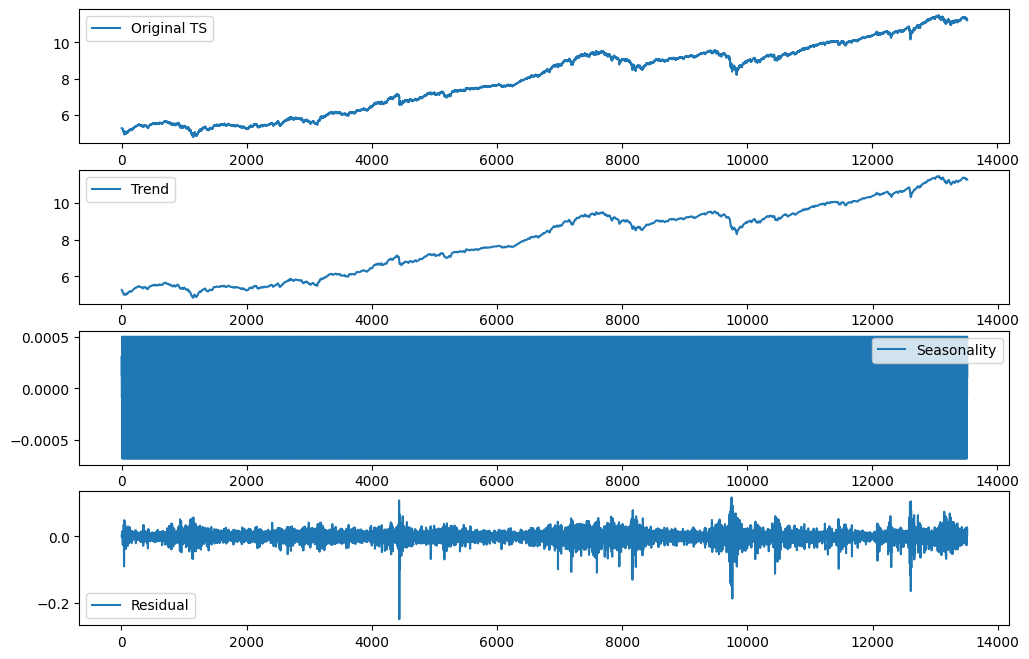

In [65]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=12)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

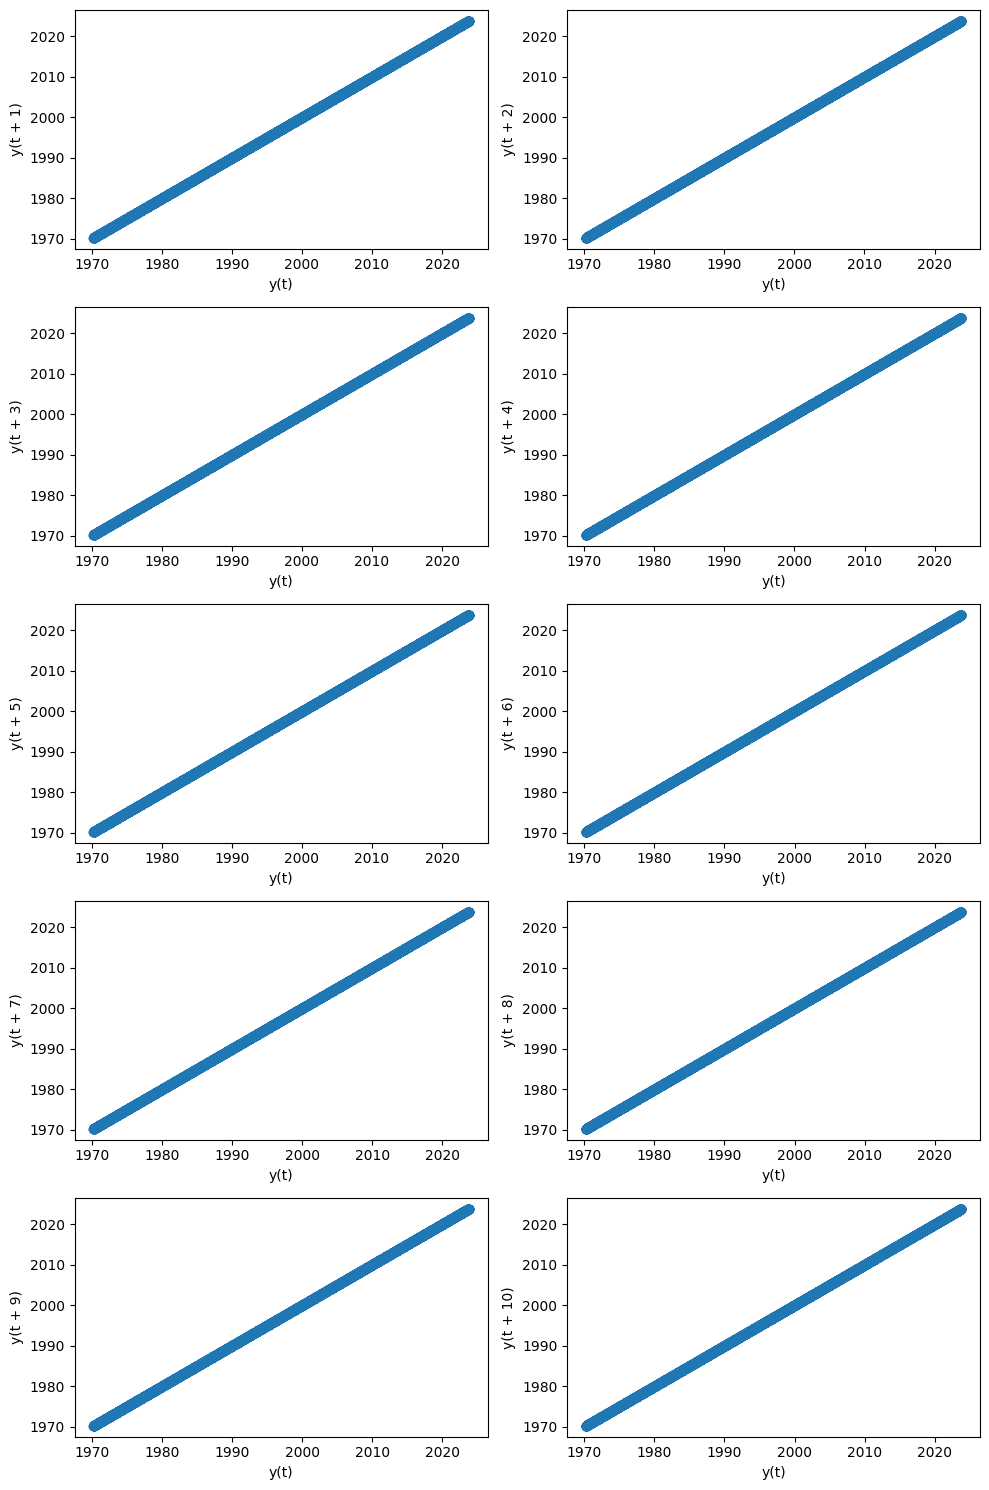

In [66]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

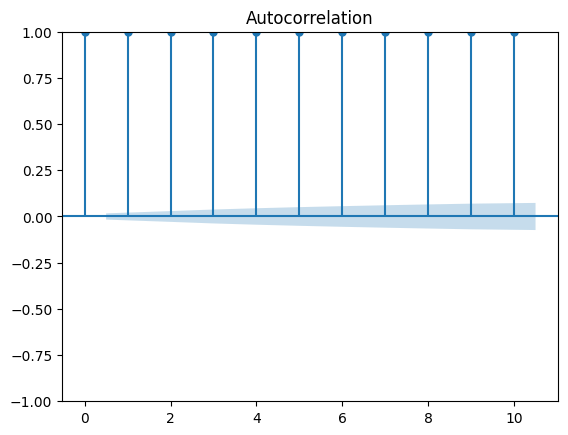

In [67]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()